# EDA++ Inteligente (Seaborn + scikit-learn) — versão com hotfix

Este caderno roda uma Análise Exploratória **inteligente** e **robusta**:
- Detecta automaticamente colunas **numéricas**, **categóricas** e **ID-like**;
- Gera correlações **Pearson** e **Spearman**;
- Calcula **Mutual Information** (não-linear);
- Estima **importâncias** com **RandomForest**;
- Exibe **PDP/ICE** para as top variáveis;
- Alerta possível **vazamento** (leakage);
- Faz **clusterização** (KMeans) e compara o alvo por cluster.

> **Requisitos**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`  
> Caso falte algo, a próxima célula tenta instalar **scikit-learn** automaticamente.


In [13]:
# %% [code] Verificação (opcional): instala scikit-learn se não existir
import importlib, sys, subprocess

def _ensure(package):
    try:
        importlib.import_module(package)
        print(f"OK: {package} já instalado.")
    except ModuleNotFoundError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

_ensure("scikit-learn")  # essencial para MI, RandomForest, PDP/ICE e KMeans
_ensure("pandas")
_ensure("numpy")
_ensure("matplotlib")
_ensure("seaborn")
print("Verificação concluída.")

Instalando scikit-learn...
OK: pandas já instalado.
OK: numpy já instalado.
OK: matplotlib já instalado.
OK: seaborn já instalado.
Verificação concluída.


In [14]:
# %% [code] CONFIGURAÇÃO INICIAL + helpers de compatibilidade
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import KMeans

sns.set(style="whitegrid", palette="viridis", font_scale=1.05)

# -----------------------------
# Parâmetros
# -----------------------------
# Preferência do usuário: caminho no iCloud (VS Code local)
CSV_PATH_icloud = Path("/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv")
# Alternativa: arquivo enviado aqui no chat
CSV_PATH_chat = Path("/mnt/data/full_warehouse_merged.csv")

# O notebook escolhe automaticamente o primeiro que existir
CSV_PATH = CSV_PATH_icloud if CSV_PATH_icloud.exists() else CSV_PATH_chat

TARGET_CANDIDATES = ["annual_medical_cost", "annual_premium", "monthly_premium"]
LOW_CARDINALITY_MAX = 30
MAX_TOP = 15
SAMPLE_PLOTS = 8000
N_CLUSTERS = 4
SAVE_FIGS = False
FIG_DPI = 110

def savefig_maybe(name):
    if SAVE_FIGS:
        out = Path("figs"); out.mkdir(exist_ok=True)
        plt.savefig(out / f"{name}.png", dpi=FIG_DPI, bbox_inches="tight")

def tight_title(t, w=80):
    import textwrap
    return "\n".join(textwrap.wrap(t, width=w))

# -----------------------------
# Compatibilidade entre versões (OHE, KMeans)
# -----------------------------
_OHE_KW = {}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    _OHE_KW["sparse_output"] = False
else:
    _OHE_KW["sparse"] = False

def _kmeans(n_clusters=4, random_state=42):
    try:
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    except TypeError:
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)

In [15]:
# %% [code] FUNÇÕES AUXILIARES
def detect_columns(df: pd.DataFrame):
    n = len(df)
    id_like = []
    for c in df.columns:
        cname = c.lower()
        nunq = df[c].nunique(dropna=False)
        if ("id" in cname) or (df[c].dtype == "object" and nunq >= 0.9*n):
            id_like.append(c)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Inteiros de baixa cardinalidade => categóricos adicionais
    for c in num_cols:
        if df[c].nunique(dropna=False) <= LOW_CARDINALITY_MAX and c not in id_like:
            if c not in cat_cols:
                cat_cols.append(c)

    num_cols = [c for c in num_cols if c not in id_like]
    cat_cols = [c for c in cat_cols if c not in id_like]

    return id_like, num_cols, cat_cols

def pick_target(df, candidates):
    for c in candidates:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return None
    corr = df[num_cols].corr(numeric_only=True).abs().mean().sort_values(ascending=False)
    return corr.index[0]

def infer_task_type(y: pd.Series):
    if pd.api.types.is_numeric_dtype(y):
        nunq = y.nunique(dropna=True)
        if nunq == 2:
            return "classification"
        return "regression"
    return "classification"

def plot_missingness(df):
    plt.figure(figsize=(12, 4))
    sns.heatmap(df.isna()[sorted(df.columns)], cbar=False)
    plt.title("Mapa de Valores Ausentes por Coluna")
    plt.xlabel("Colunas")
    plt.ylabel("Linhas (amostra visual)")
    savefig_maybe("01_missingness_heatmap")
    plt.show()

def corr_heatmap(df, drop_cols=None, method="pearson", title="Matriz de Correlação"):
    drop_cols = drop_cols or []
    corr = df.drop(columns=drop_cols, errors="ignore").corr(numeric_only=True, method=method)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(tight_title(f"{title} ({method})"))
    savefig_maybe(f"02_corr_{method}")
    plt.show()
    return corr

def compute_mutual_information(df, target, num_cols, cat_cols, task):
    # Robusto: object -> fillna -> category (sem .cat.add_categories)
    X = df[num_cols + cat_cols].copy()
    y = df[target].copy()

    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())

    for c in cat_cols:
        X[c] = X[c].astype("object").fillna("MISSING").astype("category")

    X_num = X[num_cols]
    if cat_cols:
        X_cat = pd.get_dummies(X[cat_cols], drop_first=False)
        X_enc = pd.concat([X_num, X_cat], axis=1)
    else:
        X_enc = X_num

    if task == "regression":
        mi = mutual_info_regression(X_enc, y, random_state=42)
    else:
        mi = mutual_info_classif(X_enc, y, random_state=42)

    mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
    print("\n[MI] Top variáveis por Mutual Information:")
    print(mi_series.head(MAX_TOP))
    return mi_series

def rf_feature_importance(df, target, num_cols, cat_cols, task):
    y = df[target]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True))
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", **_OHE_KW))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ],
        remainder="drop"
    )

    if task == "regression":
        model = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
    else:
        model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)

    pipe = Pipeline(steps=[("pre", pre), ("rf", model)])
    pipe.fit(df[num_cols + cat_cols], y)

    feat_names = list(num_cols)
    if cat_cols:
        ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
        try:
            cat_out = ohe.get_feature_names_out(cat_cols).tolist()
        except TypeError:
            cat_out = ohe.get_feature_names(cat_cols).tolist()
        feat_names = num_cols + cat_out

    importances = pipe.named_steps["rf"].feature_importances_
    imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)

    print("\n[RF] Top variáveis por importância (RandomForest):")
    print(imp_series.head(MAX_TOP))
    return pipe, imp_series

def plot_pdp_ice(pipe, df, target, features_to_plot, num_cols, cat_cols, task):
    if not features_to_plot:
        return
    X = df[num_cols + cat_cols]
    top_for_pdp = features_to_plot[:6]
    fig, axs = plt.subplots(len(top_for_pdp), 1, figsize=(8, 4*len(top_for_pdp)))
    if len(top_for_pdp) == 1:
        axs = [axs]
    for ax, feat in zip(axs, top_for_pdp):
        try:
            PartialDependenceDisplay.from_estimator(
                pipe, X, [feat], ax=ax, kind="both", grid_resolution=30
            )
            ax.set_title(tight_title(f"Efeito parcial (PDP/ICE): {feat} → {target}"))
        except Exception as e:
            ax.set_title(f"[PDP] Falhou para {feat}: {e}")
    plt.tight_layout()
    savefig_maybe("08_pdp_ice")
    plt.show()

def simple_leakage_scan(df, target, id_like):
    leaks = []
    for c in df.columns:
        if c == target or c in id_like:
            continue
        if pd.api.types.is_numeric_dtype(df[c]) and pd.api.types.is_numeric_dtype(df[target]):
            corr = df[[c, target]].corr(numeric_only=True).iloc[0,1]
            if abs(corr) > 0.9:
                leaks.append((c, corr))
    if leaks:
        print("\n[ALERTA] Possível vazamento (features ~ alvo):")
        for c, r in leaks:
            print(f" - {c}: corr={r:.3f}")
    else:
        print("\n[Vazamento] Nenhum vazamento óbvio detectado (correlação > 0.9).")

def run_kmeans_segmentation(df, num_cols, n_clusters=4):
    if len(num_cols) < 2:
        print("\n[KMeans] Menos de 2 variáveis numéricas — pulando clusterização.")
        return None, None
    X = df[num_cols].copy()
    X = X.fillna(X.median())
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    km = _kmeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(Xs)
    print(f"\n[KMeans] Inércia: {km.inertia_:.2f} | Clusters: {n_clusters}")
    return labels, km


Lendo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Formato: (64800, 59)

Colunas ID-like (excluídas): ['person_id', 'total_claims_paid', 'kidney_disease', 'provider_quality', 'cost_id', 'policy_id', 'record_id', 'visit_id']
Numéricas: ['annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history', 'liver_disease'] ...
Categóricas: ['plan_type', 'network_tier', 'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq', 'claims_count', 'hypertension'] ...

Alvo selecionado: annual_medical_cost
Tarefa inferida: regression


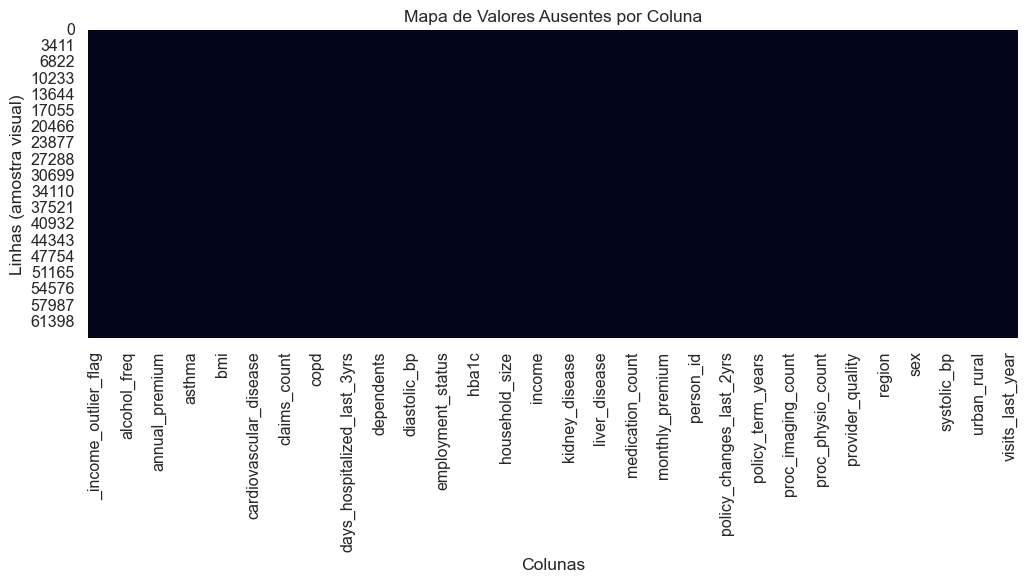

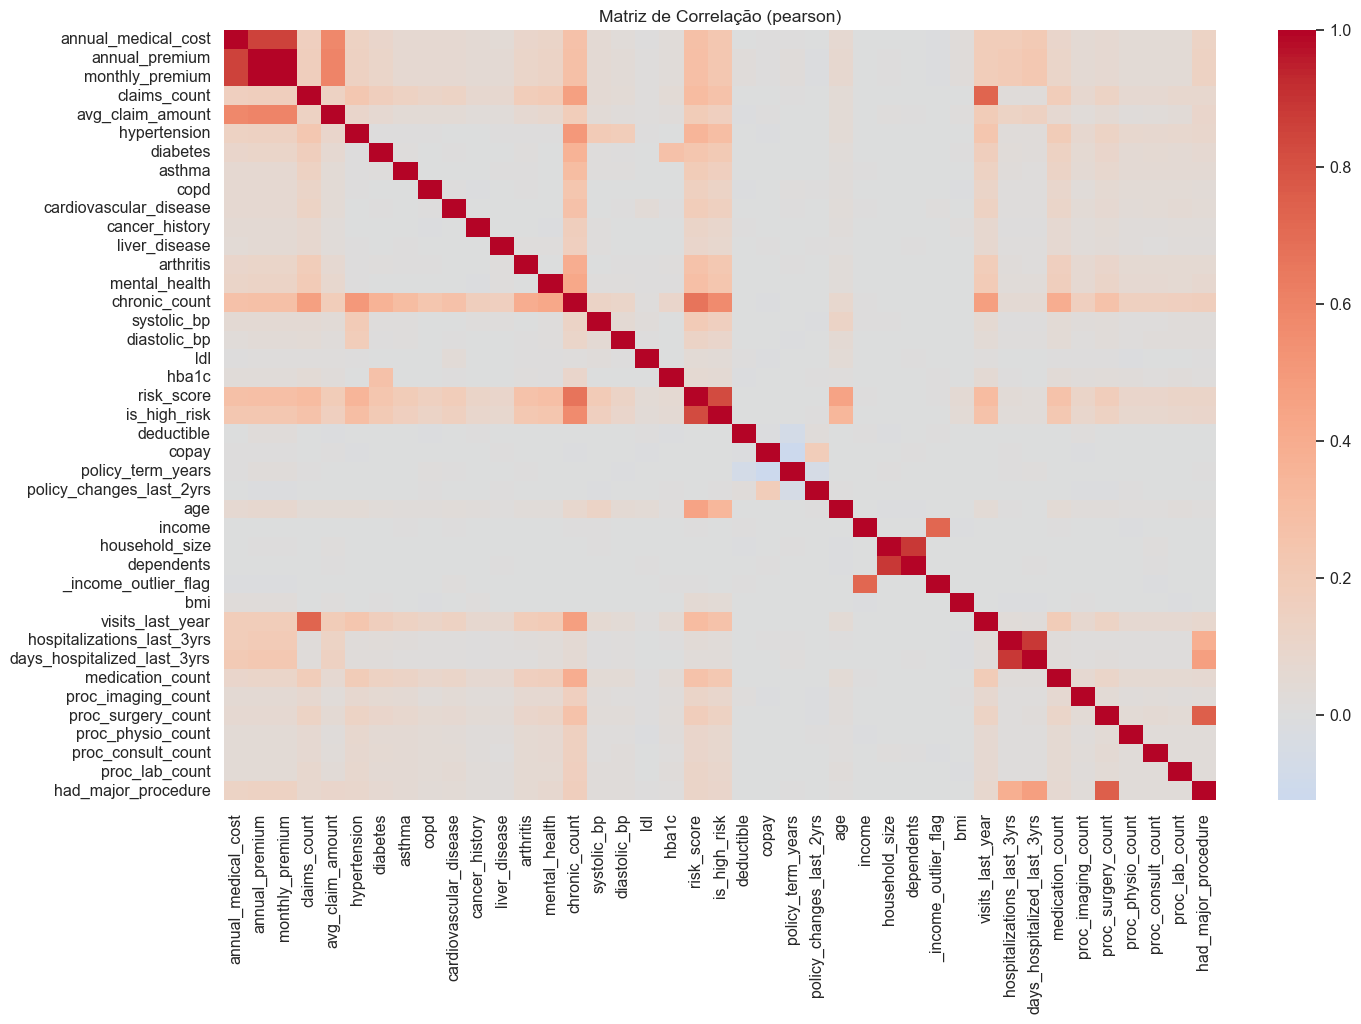

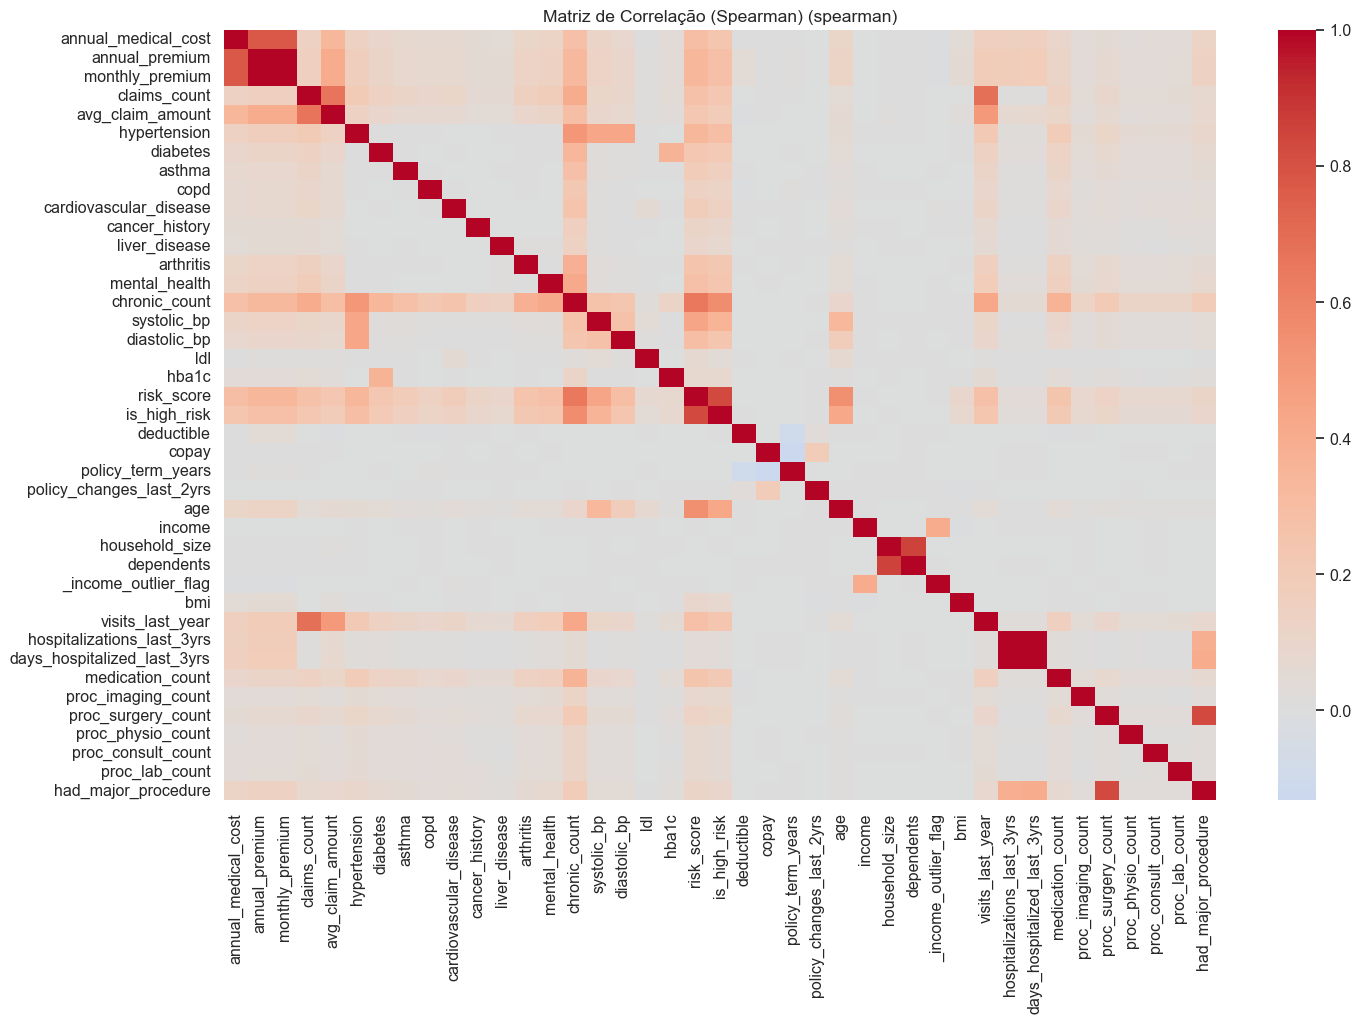


[Corr] Top com alvo (Pearson):
annual_premium                 0.855609
monthly_premium                0.855609
avg_claim_amount               0.578975
risk_score                     0.276581
chronic_count                  0.269804
is_high_risk                   0.227714
days_hospitalized_last_3yrs    0.207844
hospitalizations_last_3yrs     0.187048
visits_last_year               0.179127
claims_count                   0.161566
hypertension                   0.142044
had_major_procedure            0.133307
mental_health                  0.116688
medication_count               0.103851
diabetes                       0.100780
Name: annual_medical_cost, dtype: float64


TypeError: arg must be a list, tuple, 1-d array, or Series

In [16]:
# %% [code] EXECUÇÃO PRINCIPAL
print(f"Lendo: {CSV_PATH}")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Arquivo não encontrado em {CSV_PATH}. Ajuste o caminho CSV_PATH_icloud ou CSV_PATH_chat.")

df = pd.read_csv(CSV_PATH)
print("Formato:", df.shape)

# Detecta colunas
id_like, num_cols, cat_cols = detect_columns(df)
print("\nColunas ID-like (excluídas):", id_like)
print("Numéricas:", num_cols[:12], "..." if len(num_cols) > 12 else "")
print("Categóricas:", cat_cols[:12], "..." if len(cat_cols) > 12 else "")

# Alvo
target = pick_target(df, TARGET_CANDIDATES)
if target is None:
    raise ValueError("Não foi possível determinar o alvo. Ajuste TARGET_CANDIDATES.")
print(f"\nAlvo selecionado: {target}")

# Tipo de tarefa
task = infer_task_type(df[target])
print(f"Tarefa inferida: {task}")

# Missing
plot_missingness(df)

# Correlações
corr_p = corr_heatmap(df, drop_cols=id_like, method="pearson", title="Matriz de Correlação")
corr_s = corr_heatmap(df, drop_cols=id_like, method="spearman", title="Matriz de Correlação (Spearman)")

# Top correlações absolutas com o alvo (Pearson)
if target in corr_p.columns:
    s_top = corr_p[target].drop(labels=[target]).abs().sort_values(ascending=False)
    print("\n[Corr] Top com alvo (Pearson):")
    print(s_top.head(MAX_TOP))
else:
    s_top = pd.Series(dtype=float)

# Mutual Information
mi_series = compute_mutual_information(df, target, [c for c in num_cols if c != target], cat_cols, task)

# RandomForest Feature Importance
pipe, rf_imp = rf_feature_importance(df, target, [c for c in num_cols if c != target], cat_cols, task)

# Ranking consenso (normalização min-max e média)
consensus = pd.DataFrame({"corr_abs": s_top}).join(mi_series.rename("mi"), how="outer").join(rf_imp.rename("rf"), how="outer")
for c in ["corr_abs", "mi", "rf"]:
    if c in consensus and consensus[c].notna().any():
        col = consensus[c]
        consensus[c] = (col - col.min()) / (col.max() - col.min() + 1e-9)
consensus["rank_score"] = consensus.fillna(0)[["corr_abs","mi","rf"]].mean(axis=1)
consensus = consensus.sort_values("rank_score", ascending=False)

print("\n[Ranking] Top variáveis por consenso (Corr + MI + RF):")
print(consensus.head(MAX_TOP))

# PDP/ICE para top variáveis
top_feats_for_pdp = consensus.index.tolist()[:6]
plot_pdp_ice(pipe, df, target, top_feats_for_pdp, [c for c in num_cols if c != target], cat_cols, task)

# Vazamento
simple_leakage_scan(df, target, id_like)

# Clusterização e boxplot do alvo por cluster
labels, km = run_kmeans_segmentation(df, [c for c in num_cols if c != target], n_clusters=N_CLUSTERS)
if labels is not None:
    df["_cluster"] = labels
    plt.figure(figsize=(7,5))
    sns.boxplot(data=df, x="_cluster", y=target)
    plt.title(tight_title(f"{target} por cluster (KMeans={N_CLUSTERS})"))
    savefig_maybe("09_box_target_by_cluster")
    plt.show()
    print("\n[Clusters] Tamanho por grupo:")
    print(df["_cluster"].value_counts().sort_index())

print("\n[OK] EDA++ concluída.")